In [1]:
import os
import sys

# Comprueba si el código se está ejecutando en Google Colab
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

path_absolute = ''
if IN_COLAB:
    print("El código se está ejecutando en Google Colab.")
    from google.colab import drive
    import tensorflow as tf

    drive.mount('/content/drive')
    path_absolute = '/content/drive/Othercomputers/Mi_portátil/TFM/WorkSpace/Models/neural network'

    path_workspace = '/content/drive/Othercomputers/Mi_portátil/TFM/WorkSpace/'

    # Cambia al directorio de tu carpeta en Google Drive
    os.chdir(path_absolute)

    # Lista los archivos y carpetas en el directorio actual
    contenido_carpeta = os.listdir(path_absolute)
    print("Contenido de la carpeta en Google Drive:")
    print(contenido_carpeta)

    # Verificar la GPU
    device_name = tf.test.gpu_device_name()
    if device_name != '/device:GPU:0':
        raise SystemError('GPU no encontrada')
    print(f'Encontrada GPU: {device_name}')

    # Habilitar la GPU para TensorFlow
    physical_devices = tf.config.list_physical_devices('GPU')
    if len(physical_devices) > 0:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
        print('Memoria de la GPU configurada dinámicamente')
    else:
        print('No se encontraron dispositivos GPU configurables')
else:
    print("El código se está ejecutando en un entorno local.")
    path_workspace ='C:/Users/jaime/OneDrive - Universidad de Málaga/Escritorio/UNIR/TFM/WorkSpace/'
    path_absolute = os.getcwd().replace("\\", "/")
    path_absolute = 'C:/Users/jaime/OneDrive - Universidad de Málaga/Escritorio/UNIR/TFM/WorkSpace/Models/neural network'

datasets_path = "/datasets/"
path_absolute = path_absolute+datasets_path


sys.path.append(path_workspace)

El código se está ejecutando en un entorno local.


https://www.kaggle.com/code/terminate9298/movie-recommendation-system-for-deployment/notebook

# Movie Recommendations System


Recommender System is a system that seeks to predict or filter preferences according to the user’s choices. Recommender systems are utilized in a variety of areas including movies, music, news, books, research articles, search queries, social tags, and products in general. 

This Kernel make Recommendations on basis of 
* Content Based Recommendations 
* Similarity Based Recommendations 
* Collabrative Filtering Based Recommendations  
* Recommendations based on Surpise Library
* Factors Based Recommendations
* Embedding Based Recommedations

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import ast
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics import pairwise_distances
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

from scipy.spatial.distance import cosine, correlation
from surprise import Reader, Dataset, SVD, NormalPredictor, BaselineOnly, KNNBasic, NMF
from surprise.model_selection import cross_validate, KFold ,GridSearchCV , RandomizedSearchCV

from keras.models import Sequential
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.layers import  Input, dot, concatenate
from keras.models import Model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM

import gc
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
pd.set_option('display.max_rows',50)
pd.set_option('display.max_columns', 50)

In [3]:
def reduce_mem_usage(df):
    # iterate through all the columns of a dataframe and modify the data type
    #   to reduce memory usage.        
    
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

# Content Based Recommandation System 
Content-based filtering approaches uses a series of discrete characteristics of an item in order to recommend additional items with similar properties. Content-based filtering methods are totally based on a description of the item and a profile of the user’s preferences. It recommends items based on user’s past preferences.

In [4]:
credits = pd.read_csv(path_absolute+'/tmdb_5000_credits.csv')
movies = pd.read_csv(path_absolute+'/tmdb_5000_movies.csv')

In [5]:
display(credits.head(5))
display(movies.head(5))

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


In [6]:
credits.columns = ['id','tittle','cast','crew']
movies= movies.merge(credits,on='id')
plots = movies['overview']
tfidf = TfidfVectorizer(stop_words = 'english' , max_df = 4 , min_df= 1)
plots = plots.fillna('')
tfidf_matrix = tfidf.fit_transform(plots)


In [7]:
cos_similar = linear_kernel(tfidf_matrix , tfidf_matrix)
cos_similar.shape

(4803, 4803)

In [8]:
indices = pd.Series(movies.index , index = movies['title']).drop_duplicates()

In [9]:
def get_movies(title):
    idx = indices[title]
    similar = list(enumerate(cos_similar[idx]))
    similar = sorted(similar , key = lambda x: x[1] , reverse = True)
    similar = similar[:11]
    indic = []
    for i in similar:
        indic.append(i[0])
    return movies['title'].iloc[indic]


In [10]:
get_movies('Spider-Man 3')

5                                   Spider-Man 3
564                                        Signs
1042                               Scary Movie 3
1642                                      Splice
2981                              She's All That
3901               Pokémon: Spell of the Unknown
25                                       Titanic
0                                         Avatar
1       Pirates of the Caribbean: At World's End
2                                        Spectre
3                          The Dark Knight Rises
Name: title, dtype: object

In [11]:
get_movies('Toy Story')

1541                                   Toy Story
343                                  Toy Story 2
0                                         Avatar
1       Pirates of the Caribbean: At World's End
2                                        Spectre
3                          The Dark Knight Rises
4                                    John Carter
5                                   Spider-Man 3
6                                        Tangled
7                        Avengers: Age of Ultron
8         Harry Potter and the Half-Blood Prince
Name: title, dtype: object

# Exploring MovieLens 100K Datasets

In [12]:
# readme= open('../input/movielens-100k-dataset/ml-100k/README','r') 
# print(os.listdir(path_absolute+'/ml-100k'))
# print(readme.read()) 

In [13]:
info =  pd.read_csv(path_absolute+'/u.info' , sep=" ", header = None)
info.columns = ['Counts' , 'Type']

occupation =  pd.read_csv(path_absolute+'/u.occupation' , header = None)
occupation.columns = ['Occupations']

items = pd.read_csv(path_absolute+'/u.item' , header = None , sep = "|" , encoding='latin-1')
items.columns = ['movie id' , 'movie title' , 'release date' , 'video release date' ,
              'IMDb URL' , 'unknown' , 'Action' , 'Adventure' , 'Animation' ,
              'Childrens' , 'Comedy' , 'Crime' , 'Documentary' , 'Drama' , 'Fantasy' ,
              'Film_Noir' , 'Horror' , 'Musical' , 'Mystery' , 'Romance' , 'Sci_Fi' ,
              'Thriller' , 'War' , 'Western']

data =  pd.read_csv(path_absolute+'/u.data', header= None , sep = '\t')
user =  pd.read_csv(path_absolute+'/u.user', header= None , sep = '|')
genre =  pd.read_csv(path_absolute+'/u.genre', header= None , sep = '|' )

genre.columns = ['Genre' , 'genre_id']
data.columns = ['user id' , 'movie id' , 'rating' , 'timestamp']
user.columns = ['user id' , 'age' , 'gender' , 'occupation' , 'zip code']


In [14]:
display(info)
display(user.shape)
display(items.shape)
display(data.shape)

,Counts,Type
0,943,users
1,1682,items
2,100000,ratings


(943, 5)

(1682, 24)

(100000, 4)

In [15]:
# Merging the columns with data table to better visualise
data = data.merge(user , on='user id')
data = data.merge(items , on='movie id')

In [16]:
# Data Cleaning for Model Based Recommandation System
def convert_time(x):
    return datetime.utcfromtimestamp(x).strftime('%d-%m-%Y')
def date_diff(date):
    d1 = date['release date'].split('-')[2]
    d2 = date['rating time'].split('-')[2]
    return abs(int(d2) - int(d1))

# data.drop(columns = ['movie title' , 'video release date' , 'IMDb URL'] , inplace = True)
data.dropna(subset = ['release date'] , inplace = True)

user_details = data.groupby('user id').size().reset_index()
user_details.columns = ['user id' , 'number of user ratings']
data = data.merge(user_details , on='user id')

movie_details = data.groupby('movie id').size().reset_index()
movie_details.columns = ['movie id' , 'number of movie ratings']
data = data.merge(movie_details , on='movie id')

user_details = data.groupby('user id')['rating'].agg('mean').reset_index()
user_details.columns = ['user id' , 'average of user ratings']
data = data.merge(user_details , on='user id')

movie_details = data.groupby('movie id')['rating'].agg('mean').reset_index()
movie_details.columns = ['movie id' , 'average of movie ratings']
data = data.merge(movie_details , on='movie id')


user_details = data.groupby('user id')['rating'].agg('std').reset_index()
user_details.columns = ['user id' , 'std of user ratings']
data = data.merge(user_details , on='user id')

movie_details = data.groupby('movie id')['rating'].agg('std').reset_index()
movie_details.columns = ['movie id' , 'std of movie ratings']
data = data.merge(movie_details , on='movie id')

data['age_group'] = data['age']//10
data['rating time'] = data.timestamp.apply(convert_time)
data['time difference'] = data[['release date' , 'rating time']].apply(date_diff, axis =1)

data['total rating'] = (data['number of user ratings']*data['average of user ratings'] + data['number of movie ratings']*data['average of movie ratings'])/(data['number of movie ratings']+data['number of user ratings'])
data['rating_new'] = data['rating'] - data['total rating']

del movie_details
del user_details

In [17]:
data.head()

,user id,movie id,rating,timestamp,age,gender,occupation,zip code,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Childrens,Comedy,Crime,Documentary,Drama,Fantasy,Film_Noir,Horror,Musical,Mystery,Romance,Sci_Fi,Thriller,War,Western,number of user ratings,number of movie ratings,average of user ratings,average of movie ratings,std of user ratings,std of movie ratings,age_group,rating time,time difference,total rating,rating_new
0,196,242,3,881250949,49,M,writer,55105,Kolya (1996),24-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,39,117,3.615385,3.991453,1.016065,0.995643,4,04-12-1997,0,3.897436,-0.897436
1,305,242,5,886307828,23,M,programmer,94086,Kolya (1996),24-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,222,117,3.409910,3.991453,1.079840,0.995643,2,01-02-1998,1,3.610619,1.389381
2,6,242,4,883268170,42,M,executive,98101,Kolya (1996),24-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,211,117,3.635071,3.991453,1.039461,0.995643,4,28-12-1997,0,3.762195,0.237805
3,234,242,4,891033261,60,M,retired,94702,Kolya (1996),24-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,480,117,3.122917,3.991453,0.920366,0.995643,6,27-03-1998,1,3.293132,0.706868
4,63,242,3,875747190,31,M,marketing,75240,Kolya (1996),24-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,93,117,3.118280,3.991453,0.987415,0.995643,3,01-10-1997,0,3.604762,-0.604762


# Matrix Factorization with Keras

https://www.kaggle.com/fuzzywizard/rec-sys-collaborative-filtering-dl-techniques#4)-Matrix-Factorization-using-Deep-Learning-(Keras)

In [18]:
data = data.sample(frac = 1)
data_train_x = np.array(data[['user id' , 'movie id']].values)
data_train_y = np.array(data['rating'].values)
x_train, x_test, y_train, y_test = train_test_split(data_train_x, data_train_y, test_size = 0.2, random_state = 98)
n_factors = 50
n_users = data['user id'].max()
n_movies = data['movie id'].max()

In [19]:
data.head()

,user id,movie id,rating,timestamp,age,gender,occupation,zip code,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Childrens,Comedy,Crime,Documentary,Drama,Fantasy,Film_Noir,Horror,Musical,Mystery,Romance,Sci_Fi,Thriller,War,Western,number of user ratings,number of movie ratings,average of user ratings,average of movie ratings,std of user ratings,std of movie ratings,age_group,rating time,time difference,total rating,rating_new
79264,254,103,2,886476123,44,M,educator,42647,All Dogs Go to Heaven 2 (1996),29-Mar-1996,NaN,http://us.imdb.com/M/title-exact?All%20Dogs%20...,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,159,15,3.050314,1.866667,1.036051,0.915475,4,03-02-1998,2,2.948276,-0.948276
104,771,242,4,880659235,26,M,student,15232,Kolya (1996),24-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,70,117,3.714286,3.991453,1.342104,0.995643,2,27-11-1997,0,3.887701,0.112299
38670,387,408,4,886484492,33,M,entertainment,37412,"Close Shave, A (1995)",28-Apr-1996,NaN,http://us.imdb.com/M/title-exact?Close%20Shave...,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,304,112,3.361842,4.491071,1.205320,0.771047,3,03-02-1998,2,3.665865,0.334135
66663,460,1011,4,882912205,44,F,other,60630,2 Days in the Valley (1996),27-Sep-1996,NaN,http://us.imdb.com/M/title-exact?2%20Days%20in...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,68,93,3.411765,3.225806,0.884954,0.957000,4,23-12-1997,1,3.304348,0.695652
36600,655,129,3,887426008,50,F,healthcare,60657,Bound (1996),04-Oct-1996,NaN,http://us.imdb.com/M/title-exact?Bound%20(1996),0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,685,129,2.908029,3.821705,0.732701,0.947444,5,14-02-1998,2,3.052826,-0.052826


In [30]:
data_train_x

array([[ 254,  103],
       [ 771,  242],
       [ 387,  408],
       ...,
       [ 682,  150],
       [ 538,  210],
       [ 345, 1226]], dtype=int64)

In [31]:
data_train_y

array([2, 4, 4, ..., 4, 3, 3], dtype=int64)

In [20]:
data_train_x

array([[ 254,  103],
       [ 771,  242],
       [ 387,  408],
       ...,
       [ 682,  150],
       [ 538,  210],
       [ 345, 1226]], dtype=int64)

In [21]:
data_train_y

array([2, 4, 4, ..., 4, 3, 3], dtype=int64)

In [22]:
user_input = Input(shape=(1,), name='User_Input')
user_embeddings = Embedding(input_dim = n_users+1, output_dim=n_factors, input_length=1,name='User_Embedding')(user_input)
user_vector = Flatten(name='User_Vector') (user_embeddings)

movie_input = Input(shape = (1,) , name = 'Movie_input')
movie_embeddings = Embedding(input_dim = n_movies+1 , output_dim = n_factors , input_length = 1 , name = 'Movie_Embedding')(movie_input)
movie_vector = Flatten(name = 'Movie_Vector')(movie_embeddings)

merged_vectors = concatenate([user_vector, movie_vector], name='Concatenation')
dense_layer_1 = Dense(100 , activation = 'relu')(merged_vectors)
dense_layer_3 = Dropout(.5)(dense_layer_1)
dense_layer_2 = Dense(1)(dense_layer_3)
model = Model([user_input, movie_input], dense_layer_2)

In [23]:
model.compile(loss='mean_squared_error', optimizer='adam' ,metrics = ['accuracy'] )
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 User_Input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 Movie_input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 User_Embedding (Embedding)     (None, 1, 50)        47200       ['User_Input[0][0]']             
                                                                                                  
 Movie_Embedding (Embedding)    (None, 1, 50)        84150       ['Movie_input[0][0]']            
                                                                                              

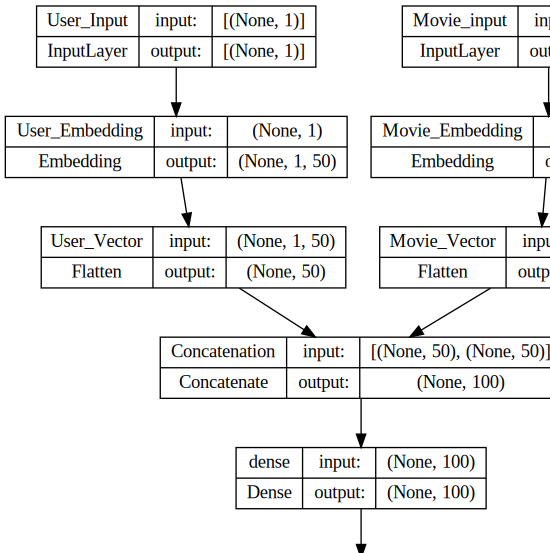

In [24]:
SVG(model_to_dot( model,  show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

In [25]:
history = model.fit(x = [x_train[:,0] , x_train[:,1]] , y =y_train , batch_size = 128 , epochs = 30 , validation_data = ([x_test[:,0] , x_test[:,1]] , y_test))

Epoch 1/30
625/625 [==============================] - 3s 4ms/step - loss: 2.2385 - accuracy: 0.0564 - val_loss: 0.9530 - val_accuracy: 0.0634
Epoch 2/30
625/625 [==============================] - 2s 4ms/step - loss: 1.1266 - accuracy: 0.0603 - val_loss: 0.9403 - val_accuracy: 0.0635
Epoch 3/30
625/625 [==============================] - 2s 4ms/step - loss: 1.0889 - accuracy: 0.0604 - val_loss: 0.9130 - val_accuracy: 0.0635
Epoch 4/30
625/625 [==============================] - 2s 4ms/step - loss: 1.0685 - accuracy: 0.0604 - val_loss: 0.9143 - val_accuracy: 0.0635
Epoch 5/30
625/625 [==============================] - 2s 4ms/step - loss: 1.0434 - accuracy: 0.0605 - val_loss: 0.9143 - val_accuracy: 0.0635
Epoch 6/30
625/625 [==============================] - 2s 4ms/step - loss: 1.0192 - accuracy: 0.0605 - val_loss: 0.9055 - val_accuracy: 0.0635
Epoch 7/30
625/625 [==============================] - 2s 4ms/step - loss: 0.9952 - accuracy: 0.0605 - val_loss: 0.9054 - val_accuracy: 0.0635
Epoch 

In [26]:
loss , val_loss , accuracy , val_accuracy = history.history['loss'],history.history['val_loss'],history.history['accuracy'],history.history['val_accuracy']

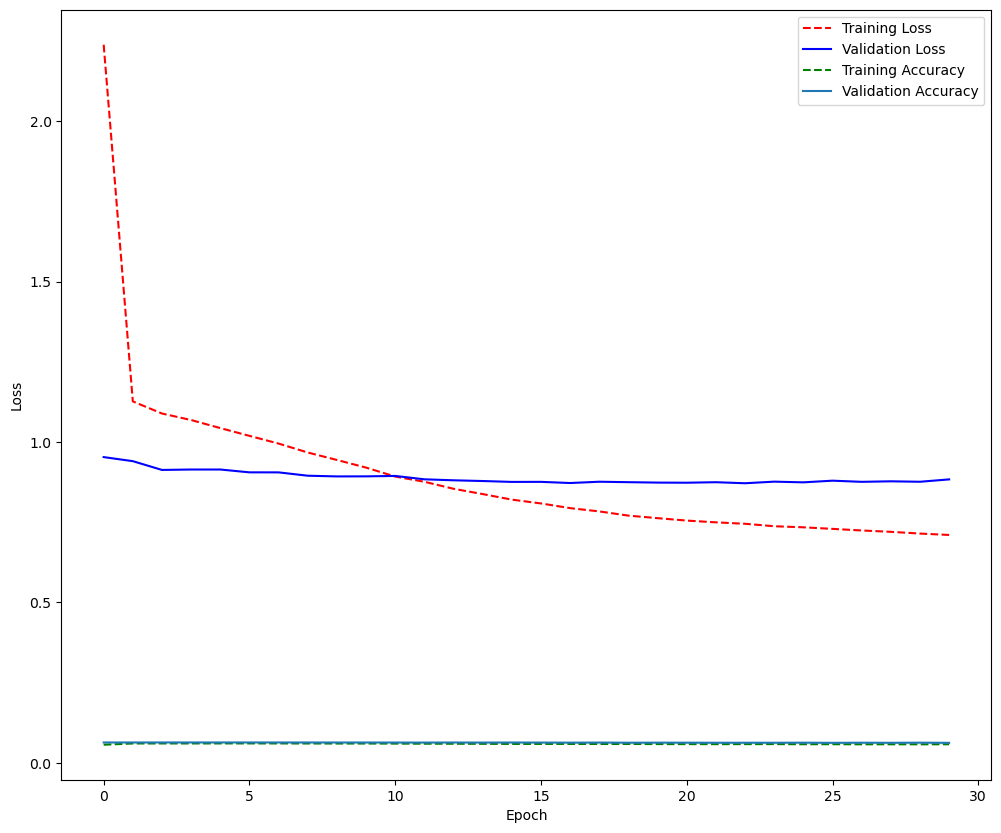

In [27]:
plt.figure(figsize = (12,10))
plt.plot( loss, 'r--')
plt.plot(val_loss, 'b-')
plt.plot( accuracy, 'g--')
plt.plot(val_accuracy,'-')
plt.legend(['Training Loss', 'Validation Loss' , 'Training Accuracy' , 'Validation Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [28]:
score = model.evaluate([x_test[:,0], x_test[:,1]], y_test)
print(np.sqrt(score))

625/625 [==============================] - 1s 2ms/step - loss: 0.8835 - accuracy: 0.0623
[0.93995073 0.24960592]


# Recommendation_systems_paperlist 
## Survey paper
* Recommender systems survey [Knowledge-based systems 2013]
* Deep Learning based Recommender System: A Survey and New Perspectives [2017]
* A Survey on Session-based Recommender System [2019] [[__pdf__](https://arxiv.org/pdf/1902.04864.pdf)]

## Recommendation Systems with Social Information 
* SoRec: Social Recommendation Using Probabilistic Matrix Factorization [CIKM 2008]
* A Matrix Factorization Technique with Trust Propagation for Recommendation in Social Networks [RecSys 2010]
* Recommender systems with social regularization [WSDM 2011]
* On Deep Learning for Trust-Aware Recommendations in Social Networks [IEEE 2017]
* Learning to Rank with Trust and Distrust in Recommender Systems [RecSys 2017]
* Social Attentional Memory Network: Modeling Aspect- and Friend-level Differences in Recommendation [WSDM 2019]
    - code : https://github.com/chenchongthu/SAMN
* Session-based Social Recommendation via Dynamic Graph Attention Networks [WSDM 2019]
  - code : https://github.com/DeepGraphLearning/RecommenderSystems/tree/master/socialRec
* Dual Graph Attention Networks for Deep Latent Representation of Multifaceted Social Effects in Recommender Systems [WWW 2019]
* Heterogeneous Graph Attention Network [WWW 2019]
* Graph Neural Networks for Social Recommendation [WWW 2019]
* GhostLink: Latent Network Inference for Influence-aware Recommendation [WWW 2019]
* SamWalker: Social Recommendation with Informative Sampling Strategy [WWW 2019]
* Social Recommendation with Optimal Limited Attention [KDD 2019]

## Recommendation Systems with Text Information
  ### Topic-based approach
  * Collaborative topic modeling for recommending scientific articles [KDD 2011]
    - code : https://github.com/blei-lab/ctr
  * Hidden factors and hidden topics: understanding rating dimensions with review text [RecSys 2013]
    - code : https://github.com/lipiji/HFT
  * Jointly modeling aspects, ratings and sentiments for movie recommendation [KDD 2014]
    - code : https://github.com/nihalb/JMARS
  * Ratings meet reviews, a combined approach to recommend [RecSys 2014]
  * Exploring User-Specific Information in Music Retrieval [SIGIR 2018]
  * Aspect-Aware Latent Factor Model: Rating Prediction with Ratings and Reviews [WWW 2018]
    - code : https://github.com/hustlingchen/ALFM
  * Exploiting Ratings, Reviews and Relationships for Item Recommendations in Topic Based Social Networks [WWW 2019]
  
  ### Deep learning-based approach
  * Collaborative deep learning for recommender systems [KDD 2015]
    - code : https://github.com/js05212/CDL
  * Convolutional Matrix Factorization for Document Context-Aware Recommendation [RecSys 2016]
    - code : https://github.com/cartopy/ConvMF
  * Joint Deep Modeling of Users and Items Using Reviews for Recommendation [WSDM 2017]
    - code : https://github.com/chenchongthu/DeepCoNN
  * Transnets: Learning to transform for recommendation [RecSys 2017]
    - code : https://github.com/rosecatherinek/TransNets
  * Latent Cross: Making Use of Context in Recurrent Recommender Systems [WSDM 2018]
  * Coevolutionary Recommendation Model: Mutual Learning between Ratings and Reviews [WWW 2018]
  * Neural Attentional Rating Regression with Review-level Explanations [WWW 2018]
    - code : https://github.com/chenchongthu/NARRE
  * Learning Personalized Topical Compositions with Item Response Theory [WSDM 2019]
  * Uncovering Hidden Structure in Sequence Data via Threading Recurrent Models [WSDM 2019]
  * Gated Attentive-Autoencoder for Content-Aware Recommendation [WSDM 2019]
    - code : https://github.com/allenjack/GATE
  * DAML: Dual Attention Mutual Learning between Ratings and Reviews for Item Recommendation [KDD 2019]   
    
## Explainable Recommendation Systems
* Social Collaborative Viewpoint Regression with Explainable Recommendations [WSDM 2017]
* Explainable Recommendation via Multi-Task Learning in Opinionated Text Data [SIGIR 2018]
* TEM: Tree-enhanced Embedding Model for Explainable Recommendation [WWW 2018]

## Session-Based Recommendation Systems
### Markov-chain based approach
* Factorizing Personalized Markov Chains for Next-Basket Recommendation [WWW 2010]
* Where You Like to Go Next: Successive Point-of-Interest Recommendation [IJCAI 2013]
* Learning Hierarchical Representation Model for NextBasket Recommendation [SIGIR 2015]
* Fusing Similarity Models with Markov Chains for Sparse Sequential Recommendation [ICDM 2016]
* Translation-based Recommendation [RecSys 2017]
    - code : https://drive.google.com/file/d/0B9Ck8jw-TZUEVmdROWZKTy1fcEE/view
    
### RNN based approach
* Session-based Recommendations with Recurrent Neural Networks [ICLR 2016]
  - code : https://github.com/hidasib/GRU4Rec
* Neural Attentive Session-based Recommendation [CIKM 2017]
  - code : https://github.com/lijingsdu/sessionRec_NARM
* Personalizing Session-based Recommendations with Hierarchical Recurrent Neural Networks [RecSys 2017]
* When Recurrent Neural Networks meet the Neighborhood for Session-Based Recommendation [RecSys 2017]
* Modeling User Session and Intent with an Attention-based Encoder-Decoder Architecture [RecSys 2017]
* Learning from History and Present: Next-item Recommendation via Discriminatively Exploting Users Behaviors [KDD 2018]
* Recurrent Neural Networks with Top-k Gains for Session-based Recommendations [CIKM 2018]
* Hierarchical Context enabled Recurrent Neural Network for Recommendation. [AAAI 2019] 
* RepeatNet: A Repeat Aware Neural Recommendation Machine for Session-based Recommendation [AAAI 2019]
  - code : https://github.com/PengjieRen/RepeatNet
* Time is of the Essence: a Joint Hierarchical RNN and Point Process Model for Time and Item Predictions [WSDM 2019]
  - code : https://github.com/BjornarVass/Recsys
* Predicting Dynamic Embedding Trajectory in Temporal Interaction Networks [KDD 2019]
* AIR: Attentional Intention-Aware Recommender Systems [ICDE 2019]

### CNN based approach 
* 3D Convolutional Networks for Session-based Recommendation with Content Features [RecSys 2017]
* Personalized Top-N Sequential Recommendation via Convolutional Sequence Embedding [WSDM 2018]
  - code : https://github.com/graytowne/caser_pytorch [Pytorch]
  - code : https://github.com/graytowne/caser [Matlab]
* Hierarchical Temporal Convolutional Networks for Dynamic Recommender Systems [WWW 2019]
* A Simple Convolutional Generative Network for Next Item Recommendation [WSDM 2019]
  - code : https://github.com/graytowne/caser_pytorch
  
### Graph based approach
* Billion-scale Commodity Embedding for E-commerce Recommendation in Alibaba [KDD 2018]
* Graph Convolutional Neural Networks for Web-Scale Recommender Systems [KDD 2018]
* Session-based Recommendation with Graph Neural Networks [AAAI 2019]
  - code : https://github.com/CRIPAC-DIG/SR-GNN
* Session-based Social Recommendation via Dynamic Graph Attention Networks [WSDM 2019]
  - code : https://github.com/DeepGraphLearning/RecommenderSystems/tree/master/socialRec  
* Graph Contextualized Self-Attention Network for Session-based Recommendation [IJCAI 2019]

### Other approach
* Diversifying Personalized Recommendation with User-session Context [IJCAI 2017]
* Translation-based Factorization Machines for Sequential Recommendation [RecSys 2018]
* Attention-Based Transactional Context Embedding for Next-Item Recommendation [AAAI 2018]
* STAMP: Short-Term Attention/Memory Priority Model for Session-based Recommendation [KDD 2018]
  - code : https://github.com/uestcnlp/STAMP
* Self-Attentive Sequential Recommendation [ICDM 2018]
  - code : https://github.com/kang205/SASRec
* Taxonomy-aware Multi-hop Reasoning Networks for Sequential Recommendation [WSDM 2019]
  - code : https://github.com/RUCDM/TMRN
* Hierarchical Neural Variational Model for Personalized Sequential Recommendation [WWW 2019]
* BERT4Rec: Sequential Recommendation with Bidirectional Encoder Representations from Transformer [CIKM 2019]
* Hierarchical Gating Networks for Sequential Recommendation [KDD 2019]
* Online Purchase Prediction via Multi-Scale Modeling of Behavior Dynamics [KDD 2019]
* Streaming Session-based Recommendation [KDD 2019]
* Hierarchical Gating Networks for Sequential Recommendation [KDD 2019]
* Log2Intent: Towards Interpretable User Modeling via Recurrent Semantics Memory Unit [KDD 2019]

### News Recommendation
* Google news personalization: scalable online collaborative filtering [WWW 2007]
* Personalized News Recommendation Based on Click Behavior [IUI 2009]
* Personalized News Recommendation Using Twitter [IEEE 2013]
* Recommending Personalized News in Short User Sessions [RecSys 2017]
* Embedding-based News Recommendation for Millions of Users [KDD 2017]
* DKN: Deep Knowledge-Aware Network for News Recommendation [WWW 2018] 
* NPA: Neural News Recommendation with Personalized Attention [KDD 2019]

### Video Recommendation
* Video suggestion and discovery for youtube: taking random walks through the view graph [WWW 2008]
* The YouTube Video Recommendation System [RecSys 2010]
* Deep Neural Networks for YouTube Recommendations [RecSys 2016]
* Wide & Deep Learning for Recommender Systems [DLRS 2016]
* Content-based Related Video Recommendations [NIPS 2016]

### Music Recommendation
* Playlist prediction via metric embedding [KDD 2012]
* Deep content-based music recommendation [NIPS 2013]
* Improving Content-based and Hybrid Music Recommendation using Deep Learning [MM 2014]
* Content-aware collaborative music recommendation using pre-trained neural networks [ISMIR 2015] 

### Image Recommendation
* Pagerank for product image search [WWW 2008]
* Related Pins at Pinterest: The Evolution of a Real-World Recommender System [WWW 2017]
* Pixie: A System for Recommending 3+ Billion Items to 200+ Million Users in Real-Time [WWW 2018]

## Time-aware Recommendation (Temporal Dynamics)
* Time Weight Collaborative Filtering [CIKM 2005]
* Collaborative Filtering with Temporal Dynamics [KDD 2009]
* Opportunity Models for E-commerce Recommendation: Right Product, Right Time [SIGIR 2013] 
* Multi-rate deep learning for temporal recommendation [SIGIR 2016]
* Recurrent Recommender Networks [WSDM 2017]
* Recurrent Recommendation with Local Coherence [WSDM 2019]

## Multi-Armed Bandit
* A Contextual-Bandit Approach to Personalized News Article Recommendation [WWW 2010]
* A survey of online experiment design with the stochastic multi-armed bandit [2015] [[__pdf__](https://arxiv.org/pdf/1510.00757.pdf)]
* Collaborative filtering as a multi-armed bandit [NIPS 2015]
* Online Context-Aware Recommendation with Time Varying Multi-Arm Bandit [KDD 2016]
* Collaborative Filtering Bandits [SIGIR 2016]

## Out of Category
* Learning Multiple Similarities of Users and Items in Recommender Systems [ICDM 2017]
* Neural Collaborative Filtering [WWW 2017]
* MRNet-Product2Vec: A Multi-task Recurrent Neural Network for Product Embeddings [ECML-PKDD 2017]
* A Gradient-based Adaptive Learning Framework for Efficient Personal Recommendation [RecSys 2017]
* IRGAN: A Minimax Game for Unifying Generative and Discriminative Information Retrieval Models [SIGIR 2017]
  - code : https://github.com/geek-ai/irgan
* Collaborative Memory Network for Recommendation Systems [SIGIR 2018]
  - code : https://github.com/tebesu/CollaborativeMemoryNetwork
* Variational Autoencoders for Collaborative Filtering [WWW 2018]
* Latent Relational Metric Learning via Memory-based Attention for Collaborative Ranking [WWW 2018]
* Causal Embeddings for Recommendation [RecSys 2018] 
  - https://github.com/criteo-research/CausE
* Linked Variational AutoEncoders for Inferring Substitutable and Supplementary Items [WSDM 2019]
  - https://github.com/VRM1/WSDM19
* RecWalk: Nearly Uncoupled Random Walks for Top-N Recommendation [WSDM 2019]
  - https://github.com/nikolakopoulos/RecWalk

